# Aimes, Iowa Housing Data: Preprocessing, Model Fitting and Analysis (All Terms, Lasso Regression)

We now look at the results of throwing in all terms and using Lasso regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import patsy
from sklearn.metrics import mean_squared_error
from functools import reduce

import pickle

np.random.seed(1)

In [2]:
fileObj = open('./pickles/housingDF.pkl', 'rb')
housing = pickle.load(fileObj)
fileObj.close()

The predictors of this model will simply be every column and dummy applicable.

In [3]:
terms = reduce((lambda x,y: x + ' + ' + y),housing.drop('SalePrice', axis=1).columns)
formula = f'SalePrice ~ {terms} - 1'
y, x = patsy.dmatrices(formula, housing)
x = pd.DataFrame(x, columns=x.design_info.column_names)

In [4]:
model = LassoCV(n_alphas=100, cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
ytrain = ytrain.ravel()
ytest = ytest.ravel()

In [5]:
model.fit(xtrain, ytrain)
print(f'The model\'s R^2 score is {model.score(xtrain, ytrain)} on the training data, {model.score(xtest, ytest)} on the test data.')

The model's R^2 score is 0.9483310354370716 on the training data, 0.9102442274298483 on the test data.


In [6]:
mean_squared_error(ytest, model.predict(xtest))**0.5

24327.577673458913

This model performs much better, having access to more information.  We can confirm some of the more important terms here.

In [7]:
pd.Series(model.coef_, index=x.columns).abs().sort_values(ascending=False)[:20]

GrLivArea                  25940.178969
ExterQual[T.TA]            10672.837772
OverallQual                10578.671001
YearBuilt                   9859.740276
ExterQual[T.Gd]             9240.926980
KitchenQual[T.TA]           8601.127682
KitchenQual[T.Gd]           7534.185807
TotalBsmtSF                 7419.920247
BsmtFinSF1                  6740.300765
Neighborhood[T.NridgHt]     6193.190125
BsmtQual[T.Ex]              5201.686593
OverallCond                 5189.521216
GarageArea                  4971.618121
GarageQual[T.Ex]            4769.199026
Functional[T.Typ]           4639.336526
LotArea                     4584.772201
SaleType[T.New]             4429.732539
Neighborhood[T.StoneBr]     4133.594737
MasVnrArea                  4063.305170
Neighborhood[T.NoRidge]     3821.009567
dtype: float64

In [8]:
scores = cross_val_score(model, xtrain, ytrain.ravel(), cv=10)
print(f'With 10 folds, the R^2 score is {np.mean(scores)} +- {np.std(scores)}')

With 10 folds, the R^2 score is 0.9240048754482115 +- 0.015304989109232458


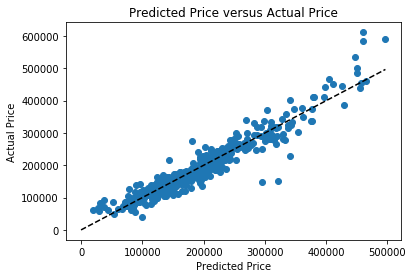

In [9]:
plt.scatter(model.predict(xtest), ytest);
plt.title('Predicted Price versus Actual Price')
plt.plot((0,max(model.predict(xtest))), (0, max(model.predict(xtest))), linestyle='dashed', color='k')
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price');

There is some information in the higher end houses that we are not capturing.  We can try and see if adding interactions I think are relevant might improve the score.

In [10]:
interactions = 'BsmtFinSF1:BsmtFinType1 + GrLivArea:OverallQual + GrLivArea:OverallQual:ExterQual'
formula = f'SalePrice ~ {terms} + {interactions}- 1'
y, x = patsy.dmatrices(formula, housing)
x = pd.DataFrame(x, columns=x.design_info.column_names)

In [11]:
model = LassoCV(n_alphas=100, cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [12]:
model.fit(xtrain, ytrain.ravel())
print(f'The model\'s R^2 score is {model.score(xtrain, ytrain)} on the training data, {model.score(xtest, ytest)} on the test data.')

The model's R^2 score is 0.9461773207283232 on the training data, 0.9381332649628902 on the test data.


In [13]:
mean_squared_error(ytest, model.predict(xtest))**0.5

20399.939731875224

In [14]:
scores = cross_val_score(model, xtrain, ytrain.ravel(), cv=10)
print(f'With 10 folds, the R^2 score is {np.mean(scores)} +- {np.std(scores)}')

With 10 folds, the R^2 score is 0.9278095934935605 +- 0.019374268694359327


No change on a scale we would care about.  The dominant term is quality square footage, and external quality adds and additional effect, as advertised.

In [15]:
coefs = pd.DataFrame(model.coef_, index=x.columns, columns=['Weight']).sort_values(by='Weight', ascending=False)
coefs.abs().head(10)

,Weight
GrLivArea:OverallQual,35592.045314
TotalBsmtSF,7666.256214
YearBuilt,7588.752040
BsmtFinSF1:BsmtFinType1[T.GLQ],7577.062282
OverallCond,5616.697915
LotArea,5327.320570
BsmtQual[T.Ex],4491.753706
Neighborhood[T.NridgHt],4402.241909
SaleType[T.New],4083.364453
GrLivArea,4040.326981


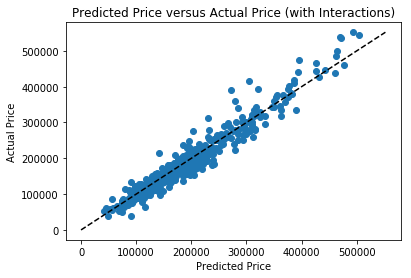

In [16]:
plt.scatter(model.predict(xtest), ytest);
plt.title('Predicted Price versus Actual Price (with Interactions)')
plt.plot((0,max(ytest)), (0, max(ytest)), linestyle='dashed', color='k')
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price');

At first glance, these predictions look closer.  In this sample, though, we did not have the nearly $600,000 houses in our test data, so it would not immediatley be fair to say that we would be prepared to predict the price of that house.  Looking to see if we were at least able to fit to it in our training data,

In [17]:
extremes = housing.loc[housing.SalePrice>590000,:]
extreme_x = xtrain[(ytrain>590000)[:,0]]
extreme_y = ytrain[ytrain>590000]
errors = extreme_y - model.predict(extreme_x)

In [18]:
print(f'The extremes are still greater by {errors[0]} and {errors[1]}')

The extremes are still greater by 132696.72359514574 and 82960.29351035785


We go ahead in submitting this model for kaggle.

In [19]:
fileFormula = open('./pickles/formula.pkl', 'wb')
pickle.dump(formula, fileFormula)
fileFormula.close()

In [20]:
fileScaler = open('./pickles/scaler.pkl', 'wb')
pickle.dump(scaler, fileScaler)
fileScaler.close()

In [21]:
fileModel = open('./pickles/model.pkl', 'wb')
pickle.dump(model, fileModel)
fileModel.close()

In [22]:
fileColumns = open('./pickles/columns.pkl', 'wb')
pickle.dump(x.columns, fileColumns)
fileColumns.close()